In [2]:
from hourglass import hg
import os
import argparse
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.utils.data import DataLoader

from dataset import PieDataset
from loss import HeatmapLoss
from utils import AverageMeter
from tqdm import tqdm
import wandb

train = PieDataset(
    '/opt/ml/final/data/piedata(1008)/pie/annotations/instancesPie(1008)_train2019.json', 
    '/opt/ml/final/data/piedata(1008)/pie/images/train2019/',
    image_size=(256,256)
)
valid = PieDataset(
    '/opt/ml/final/data/piedata(1008)/pie/annotations/instancesPie(1008)_val2019.json', 
    '/opt/ml/final/data/piedata(1008)/pie/images/val2019/',
    image_size=(256,256)
)

train_loader = DataLoader(
                            train,
                            batch_size=64, 
                            pin_memory=True,
                            shuffle=True
)
valid_loader = DataLoader(
                            valid,
                            batch_size=64, 
                            pin_memory=True,
                            shuffle=True
)

In [3]:
device = torch.device("cuda")
model = hg( num_stacks=1,
            num_blocks=1,
            num_classes=2
            ).to(device)
criterion = HeatmapLoss().to(device)
optimizer = torch.optim.SGD(
            model.parameters(),
            lr=1e-3,
            momentum=0.9
        )
scaler = torch.cuda.amp.GradScaler()

In [4]:
x = torch.randn((32, 3, 192, 192)).to(device)
output = model(x)[0]
# new_output = torch.nn.functional.upsample(output, scale_factor=4)


In [5]:
EPOCHS = 1
TRAIN_VIS_INTERVAL = 10
VAL_PER_EPOCH = 3
wandb.init(project="OGR", entity="passion-ate", name="Hourglass_exp1")

def validate():
    print("==========Start Validation==========")
    val_loss_hist = AverageMeter()
    model.eval()
    for image, heatmap in tqdm(valid_loader, total=len(valid_loader)):

        image = image.float().to(device)
        heatmap = heatmap.float().to(device)

        with torch.no_grad():
            output = model(image)
        output = torch.nn.functional.upsample(output[-1], scale_factor=4)
        loss = criterion(output, heatmap)
        val_loss_hist.update(loss.item())
    print(
            f"[Val] loss: {val_loss_hist.val:4.2} || "
        )
    wandb.log({"Val/loss" : val_loss_hist.val})
    model.train()

for epoch in range(3):
    print(f"==========Epoch {epoch+1}==========")
    train_loss_hist = AverageMeter()
    model.train()
    for step, (image, heatmap) in enumerate(train_loader):
        

        optimizer.zero_grad()
        image = image.float().to(device)
        heatmap = heatmap.float().to(device)
        
        with torch.cuda.amp.autocast():
            output = model(image)
            output = torch.nn.functional.upsample(output[-1], scale_factor=4)
            loss = criterion(output, heatmap)
        train_loss_hist.update(loss.item())

        if (step + 1) % TRAIN_VIS_INTERVAL == 0:
            print(
                                f"Epoch[{epoch+1}/{EPOCHS}]({step + 1}/{len(train_loader)}) || "
                                f"training loss {train_loss_hist.val:4.4}"
                            )
            wandb.log({"Train/loss" : train_loss_hist.val})
            train_loss_hist.reset()
        if (step + 1) % (len(train_loader) // VAL_PER_EPOCH) == 0:
            validate()
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        
    
    


    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: youkind (use `wandb login --relogin` to force relogin)


==========Epoch 1==========


/opt/conda/envs/final/lib/python3.8/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch[1/1](10/1142) || training loss 0.05517
Epoch[1/1](20/1142) || training loss 0.04825
Epoch[1/1](30/1142) || training loss 0.03785
Epoch[1/1](40/1142) || training loss 0.02973
Epoch[1/1](50/1142) || training loss 0.0269
Epoch[1/1](60/1142) || training loss 0.02407
Epoch[1/1](70/1142) || training loss 0.02177
Epoch[1/1](80/1142) || training loss 0.02157
Epoch[1/1](90/1142) || training loss 0.01958
Epoch[1/1](100/1142) || training loss 0.01775
Epoch[1/1](110/1142) || training loss 0.01742
Epoch[1/1](120/1142) || training loss 0.01617
Epoch[1/1](130/1142) || training loss 0.01513
Epoch[1/1](140/1142) || training loss 0.01435
Epoch[1/1](150/1142) || training loss 0.01355
Epoch[1/1](160/1142) || training loss 0.01385
Epoch[1/1](170/1142) || training loss 0.01367
Epoch[1/1](180/1142) || training loss 0.0122
Epoch[1/1](190/1142) || training loss 0.01212
Epoch[1/1](200/1142) || training loss 0.01165
Epoch[1/1](210/1142) || training loss 0.01171
Epoch[1/1](220/1142) || training loss 0.01046

100%|██████████| 31/31 [00:22<00:00,  1.40it/s]


[Val] loss: 0.007 || 
===========Start Training===========
Epoch[1/1](390/1142) || training loss 0.007476
Epoch[1/1](400/1142) || training loss 0.007196
Epoch[1/1](410/1142) || training loss 0.00702
Epoch[1/1](420/1142) || training loss 0.006974
Epoch[1/1](430/1142) || training loss 0.006199
Epoch[1/1](440/1142) || training loss 0.006769
Epoch[1/1](450/1142) || training loss 0.006529
Epoch[1/1](460/1142) || training loss 0.006326
Epoch[1/1](470/1142) || training loss 0.005945
Epoch[1/1](480/1142) || training loss 0.005823
Epoch[1/1](490/1142) || training loss 0.005936
Epoch[1/1](500/1142) || training loss 0.006181
Epoch[1/1](510/1142) || training loss 0.005715
Epoch[1/1](520/1142) || training loss 0.005249
Epoch[1/1](530/1142) || training loss 0.005355
Epoch[1/1](540/1142) || training loss 0.005997
Epoch[1/1](550/1142) || training loss 0.005479
Epoch[1/1](560/1142) || training loss 0.005794
Epoch[1/1](570/1142) || training loss 0.005
Epoch[1/1](580/1142) || training loss 0.005365
Epoch

100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


[Val] loss: 0.0037 || 
===========Start Training===========
Epoch[1/1](770/1142) || training loss 0.004236
Epoch[1/1](780/1142) || training loss 0.004109
Epoch[1/1](790/1142) || training loss 0.004102
Epoch[1/1](800/1142) || training loss 0.00419
Epoch[1/1](810/1142) || training loss 0.004144
Epoch[1/1](820/1142) || training loss 0.003991
Epoch[1/1](830/1142) || training loss 0.003978
Epoch[1/1](840/1142) || training loss 0.004298
Epoch[1/1](850/1142) || training loss 0.003822
Epoch[1/1](860/1142) || training loss 0.003689
Epoch[1/1](870/1142) || training loss 0.00366
Epoch[1/1](880/1142) || training loss 0.003854
Epoch[1/1](890/1142) || training loss 0.003914
Epoch[1/1](900/1142) || training loss 0.003479
Epoch[1/1](910/1142) || training loss 0.003642
Epoch[1/1](920/1142) || training loss 0.003856
Epoch[1/1](930/1142) || training loss 0.003828
Epoch[1/1](940/1142) || training loss 0.003831
Epoch[1/1](950/1142) || training loss 0.00364
Epoch[1/1](960/1142) || training loss 0.003641
Epo

100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


[Val] loss: 0.0026 || 
===========Start Training===========
==========Epoch 2==========
Epoch[2/1](10/1142) || training loss 0.003343
Epoch[2/1](20/1142) || training loss 0.003056
Epoch[2/1](30/1142) || training loss 0.003162
Epoch[2/1](40/1142) || training loss 0.003123
Epoch[2/1](50/1142) || training loss 0.003176
Epoch[2/1](60/1142) || training loss 0.003105
Epoch[2/1](70/1142) || training loss 0.002883
Epoch[2/1](80/1142) || training loss 0.00297
Epoch[2/1](90/1142) || training loss 0.002907
Epoch[2/1](100/1142) || training loss 0.002883
Epoch[2/1](110/1142) || training loss 0.00288
Epoch[2/1](120/1142) || training loss 0.00308
Epoch[2/1](130/1142) || training loss 0.003008
Epoch[2/1](140/1142) || training loss 0.003117
Epoch[2/1](150/1142) || training loss 0.002924
Epoch[2/1](160/1142) || training loss 0.002938
Epoch[2/1](170/1142) || training loss 0.002574
Epoch[2/1](180/1142) || training loss 0.002847
Epoch[2/1](190/1142) || training loss 0.002852
Epoch[2/1](200/1142) || trainin

TypeError: unsupported operand type(s) for /: 'Image' and 'float'

/opt/conda/envs/final/lib/python3.8/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([2, 256, 256])


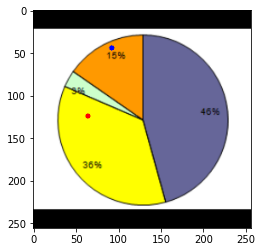

torch.Size([2, 256, 256])


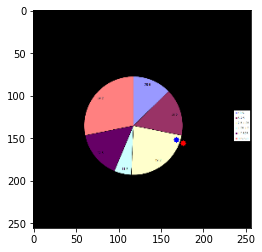

torch.Size([2, 256, 256])


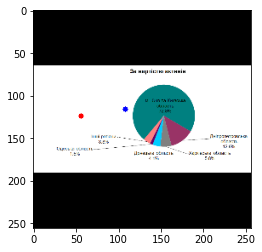

torch.Size([2, 256, 256])


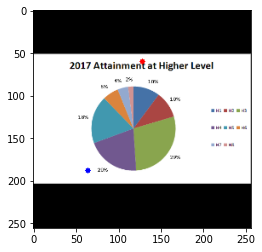

torch.Size([2, 256, 256])


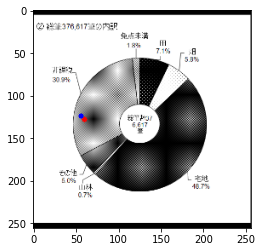

torch.Size([2, 256, 256])


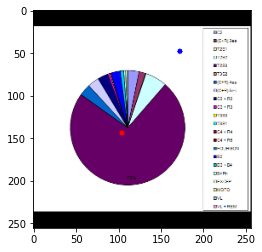

torch.Size([2, 256, 256])


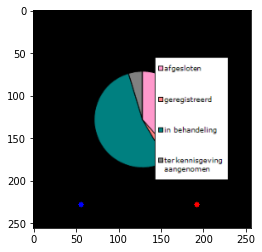

torch.Size([2, 256, 256])


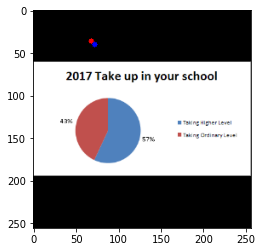

torch.Size([2, 256, 256])


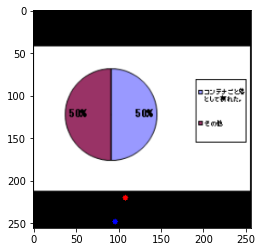

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

n_vis = 3
# Visualize the result of validation dataset
for iter, (imgs, hm_gt) in enumerate(train_loader):
    imgs = imgs.float().to(device)
    
    with torch.no_grad():
        output = model(imgs)
    output = torch.nn.functional.upsample(output[-1], scale_factor=4)


    imgs = imgs.cpu().numpy()
    for img_num, (img, pred_hm) in enumerate(zip(imgs, output)):
        # Re-convert pre-processed input image to original format
        img = np.moveaxis(img, 0, -1)
        img = (img*255).astype(np.uint8).copy()
        print(pred_hm.shape)
        for i, hm in enumerate(pred_hm):
            hm = hm.detach().cpu().numpy()
            y, x = np.unravel_index(hm.argmax(), hm.shape)
            
            if i == 0: # center
                cv2.circle(img, (x, y), 3, (255,0,0), -1)
            if i == 1: # edge
                cv2.circle(img, (x, y), 3, (0,0,255), -1)
    
        plt.imshow(img)
        plt.show()

        if img_num == (n_vis - 1):
            break

    if iter == (n_vis-1):
        break